In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neural_interaction_detection import NeuralInteractionDetectionExplainerTF
from path_explain import utils, scatter_plot, summary_plot

In [3]:
utils.set_up_environment(visible_devices='0')

In [4]:
n = 5000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + 2 * np.prod(X[:, 0:2], axis=-1)

In [5]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=5,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [8]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [9]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 1s - loss: 7.1516 - val_loss: 4.2218
Epoch 2/20
799/799 - 0s - loss: 3.4949 - val_loss: 2.0439
Epoch 3/20
799/799 - 0s - loss: 2.6187 - val_loss: 3.0671
Epoch 4/20
799/799 - 0s - loss: 1.3953 - val_loss: 1.8937
Epoch 5/20
799/799 - 0s - loss: 1.8726 - val_loss: 0.8704
Epoch 6/20
799/799 - 0s - loss: 0.9530 - val_loss: 0.2327
Epoch 7/20
799/799 - 0s - loss: 0.6763 - val_loss: 0.3884
Epoch 8/20
799/799 - 0s - loss: 0.3941 - val_loss: 1.9346
Epoch 9/20
799/799 - 0s - loss: 4.6098 - val_loss: 0.7277
Epoch 10/20
799/799 - 0s - loss: 2.1247 - val_loss: 0.2668
Epoch 11/20
799/799 - 0s - loss: 0.4663 - val_loss: 0.3896
Epoch 12/20
799/799 - 0s - loss: 0.3508 - val_loss: 0.8325
Epoch 13/20
799/799 - 0s - loss: 0.6258 - val_loss: 5.4989
Epoch 14/20
799/799 - 0s - loss: 1.0269 - val_loss: 0.2426
Epoch 15/20
799/799 - 0s - loss: 0.3054 - val_loss: 0.3093
Epoch 16/20
799/799 - 0s - loss: 0.3523 - val_loss: 0.1442
Epoch 17/20
799/79

In [10]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1000 - 0s - loss: 0.6316


0.6315549954771995

In [11]:
y_test_pred = model.predict(X_test, batch_size=50)

In [12]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})

In [13]:
def scatterplot(x, y, df, title=None):
    fig = plt.figure(dpi=100)
    ax = fig.gca()
    ax.scatter(df[x],
               df[y],
               s=10)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)
    ax.set_xlabel(x, fontsize=11)
    ax.set_ylabel(y, fontsize=11)
    ax.spines['top'].set_linewidth(0.1)
    ax.spines['right'].set_linewidth(0.1)
    ax.set_title(title)

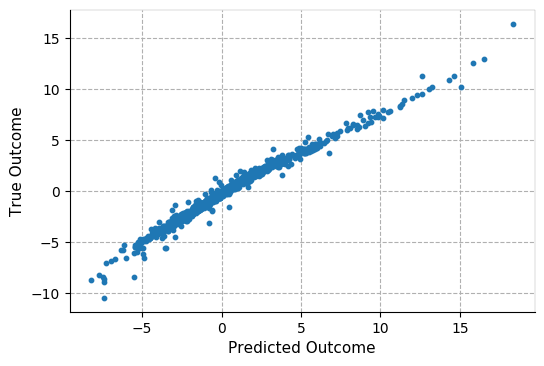

In [14]:
scatterplot('Predicted Outcome', 'True Outcome', df)

In [15]:
explainer = NeuralInteractionDetectionExplainerTF(model)

In [16]:
feature_values = X_test

In [17]:
interactions = explainer.interactions(batch_size=50,
                                      output_index=None,
                                      verbose=False)

In [19]:
interactions

array([[ 0.        , 26.11245918,  7.35325241,  8.28126144,  7.86948872],
       [26.11245918,  0.        ,  7.35325241,  8.36361599,  8.38470364],
       [ 7.35325241,  7.35325241,  0.        ,  6.14803076,  5.63367748],
       [ 8.28126144,  8.36361599,  6.14803076,  0.        ,  6.90138435],
       [ 7.86948872,  8.38470364,  5.63367748,  6.90138435,  0.        ]])

In [22]:
multiplied_interactions = interactions[np.newaxis] * feature_values[:, np.newaxis, :] * feature_values[:, :, np.newaxis]

In [26]:
data_df = pd.DataFrame({
    'Product': 2 * np.prod(feature_values[:, 0:2], axis=-1),
    'Interaction': multiplied_interactions[:, 0, 1]
})

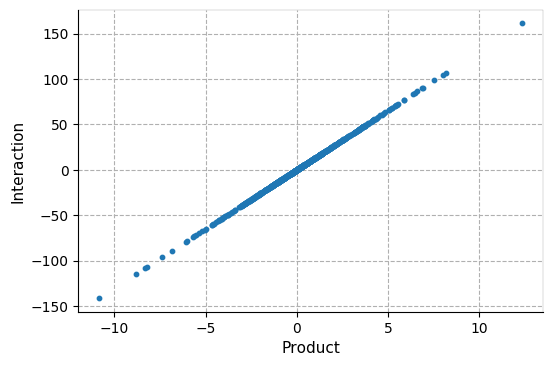

In [27]:
scatterplot('Product', 'Interaction', data_df)